# Code for competition

In [1]:
import tensorflow as tf
import numpy as np
import os
import shutil
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Enable experimental feature of memory occupation growth control 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Metadata

In [2]:
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
batch_size = 64
epochs = 400
classes = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]
static_aug = True

### Prepare the environment

In [3]:
train_split = 0.8

path = os.getcwd()
if not os.path.exists(path+'/training') and not os.path.exists(path+'/validation'):
    os.mkdir(path+'/training')
    os.mkdir(path+'/validation')

    # Destination path 
    dest_train = path + '/training'
    dest_valid = path + '/validation'

    # Source path
    source = path + '/training_data_final'

    # Create train and validation into the training and validation folders
    for folder in os.listdir(source):
        if not os.path.exists(dest_train + '/' + folder):
            os.mkdir(dest_train + '/' + folder)
        if not os.path.exists(dest_valid + '/' + folder):
            os.mkdir(dest_valid + '/' + folder)
    
        class_source = source + '/' + folder                                                   # Create path of the class
        files = os.listdir(class_source)                                                       # List of files for the class
        random.shuffle(files)
        
        # Create training set randomly
        for i in range(int(len(files) * train_split)):
            dest = shutil.copy(class_source+'/'+files[i], dest_train+'/'+folder+'/'+files[i])  # Copy an image in the training set
        
        # Create validation set randomly
        for j in range(i + 1, len(files)):
            dest = shutil.copy(class_source+'/'+files[j], dest_valid+'/'+folder+'/'+files[j])  # copy an image in the validation set

### Prepare the validation set for evaluation purposes

In [4]:
samples = []
targets = []

dest_valid = os.getcwd() + '/validation'

i=0
for folder in os.listdir(dest_valid):
    dest_class = dest_valid + '/' + folder
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0)) / 255
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
    i += 1

X_val = np.array(samples)
y_val = np.array(targets, dtype=np.uint8)
print(X_val.shape, X_val.dtype, sep=", ")
print(y_val.shape, y_val.dtype, sep=", ")

# Compute the class weights in order to balance loss during training
y_numeric = []
for v in y_val:
    y_numeric.append(np.argmax(v))

labels = np.unique(np.fromiter([np.argmax(t) for t in y_val], np.int32))
    
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))
print(class_weights)

(713, 96, 96, 3), float64
(713, 8), uint8
{0: 2.3453947368421053, 1: 0.8329439252336449, 2: 0.8652912621359223, 3: 0.8652912621359223, 4: 0.8329439252336449, 5: 1.9805555555555556, 6: 0.8252314814814815, 7: 0.8737745098039216}


### Static augmentation (only on training set)

In [5]:
if static_aug:
    old_train = os.getcwd() + '/training'
    dest_train = os.getcwd() + '/training_aug'
    shutil.copytree(old_train, dest_train)

    desired_amount = 500

    static_shift = 5
    static_gen = ImageDataGenerator(rotation_range=180,
                                        width_shift_range=static_shift,
                                        height_shift_range=static_shift,
                                        #brightness_range=(1, 1.1),
                                        #channel_shift_range=150,
                                        #shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        #vertical_flip=True,
                                        fill_mode='reflect')

    for folder in os.listdir(dest_train):
        dest_path = dest_train + '/' + folder

        to_produce = desired_amount - len(os.listdir(dest_path))
        
        static_gen_data = static_gen.flow_from_directory(dest_train,
                                                        batch_size=1,
                                                        target_size=input_size,
                                                        classes=[folder],
                                                        class_mode='categorical', # Targets are directly converted into one-hot vectors
                                                        shuffle=True,
                                                        seed=seed) 
        print(f'Computing {to_produce} augmented images for target "{folder}"')

        os.chdir(dest_path)
        for i in range(0, to_produce):
            Image.fromarray(np.squeeze(next(static_gen_data)[0]).astype(np.uint8)).save(f'aug{i:05}.jpg')
        os.chdir('../')
    os.chdir('../')
    print('\n' + os.getcwd())

Found 148 images belonging to 1 classes.
Computing 352 augmented images for target "Species1"
Found 425 images belonging to 1 classes.
Computing 75 augmented images for target "Species2"
Found 412 images belonging to 1 classes.
Computing 88 augmented images for target "Species3"
Found 408 images belonging to 1 classes.
Computing 92 augmented images for target "Species4"
Found 424 images belonging to 1 classes.
Computing 76 augmented images for target "Species5"
Found 177 images belonging to 1 classes.
Computing 323 augmented images for target "Species6"
Found 429 images belonging to 1 classes.
Computing 71 augmented images for target "Species7"
Found 406 images belonging to 1 classes.
Computing 94 augmented images for target "Species8"

c:\Users\tomma\Documents\GitHub\AN2DL-project-2022\Code


### Online augmentation
Lets create the generators we'll need...

In [6]:
shift = 10
train_data_gen = ImageDataGenerator(rotation_range=180,
                                    width_shift_range=shift,
                                    height_shift_range=shift,
                                    brightness_range=(1, 1.1),
                                    #channel_shift_range=150,
                                    #shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    #vertical_flip=True,
                                    fill_mode='reflect',
                                    rescale=1./255)

valid_data_gen = ImageDataGenerator(rescale=1./255)

... using flow_from_directory

In [7]:
# Paths
path = os.getcwd()
if static_aug:
    training_dir = path + '/training_aug'
else:
    training_dir = path + '/training'
validation_dir = path + '/validation'

# Training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)  

# Validation
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=batch_size, 
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed)

# Create Datasets objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

valid_dataset = valid_dataset.repeat()

Found 4000 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


### Models definition functions

In [8]:
def build_tl_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.InceptionV3(include_top=False,
                                            weights="imagenet",
                                            input_shape=input_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dropout(0.2, seed=seed, name='dropout')(x)
    
    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'tl_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

### Define the model

In [9]:
model = build_tl_model(input_shape)

model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 8)                 16392     
                                                                 
Total params: 21,819,176
Trainable params: 21,784,744
Non-trainable params: 34,432
_________________________________________

### Train the model

In [10]:
train_mul = 1.5
decay_rate = 5

def scheduler(epoch, lr):
    if epoch % decay_rate == (decay_rate - 1):
        return lr * tf.math.exp(-0.1)
    return lr

history = model.fit(x=train_dataset,
                    epochs=epochs,                                    # Only indicative since we set "repeat" in training and validation datasets
                    steps_per_epoch=int(len(train_gen) * train_mul),
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    #class_weight=class_weights,
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True),
                                 tf.keras.callbacks.LearningRateScheduler(scheduler)]
).history

Epoch 1/400
 5/94 [>.............................] - ETA: 1:39 - loss: 2.2276 - accuracy: 0.1656

KeyboardInterrupt: 

### Plot training results

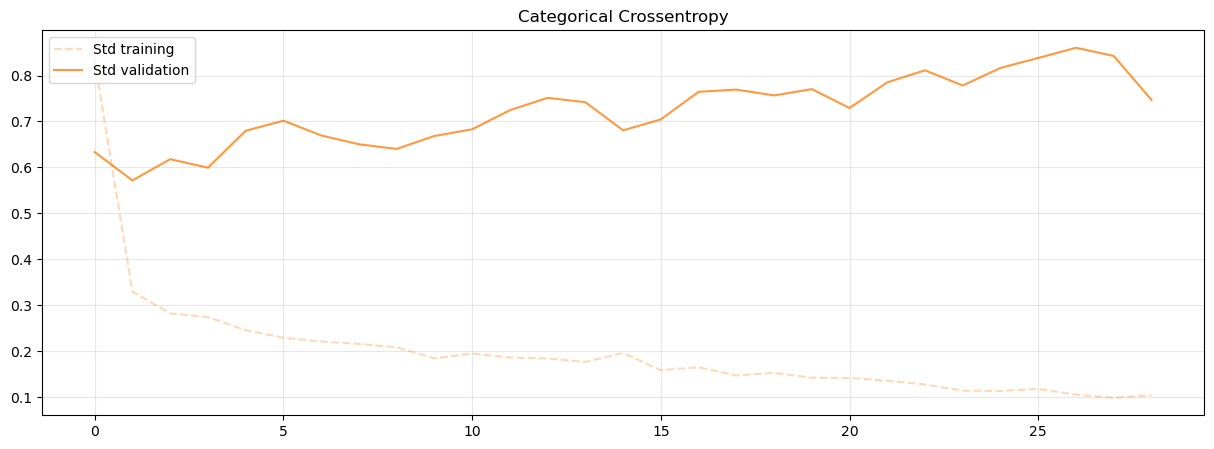

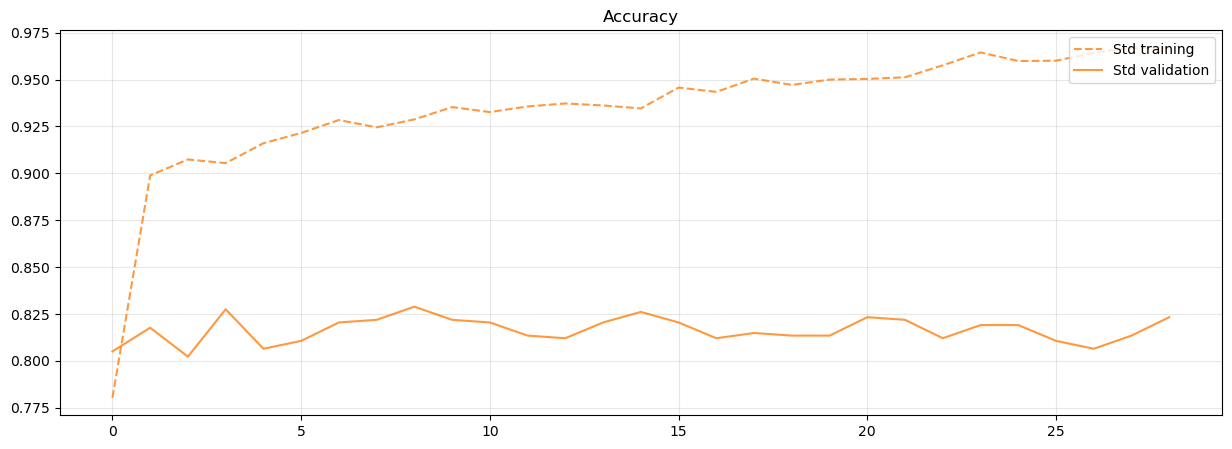

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

In [ ]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

NameError: name 'model' is not defined

### Save the model

In [ ]:
restored_model = tfk.models.load_model('best_model')
restored_loss, restored_acc = restored_model.evaluate(X_val, y_val, verbose=2)  #TODO: not right because validation set can change
loss, acc = model.evaluate(X_val, y_val, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('best_model')
else:
    print("No improvement!")

23/23 - 5s - loss: 0.8471 - accuracy: 0.7532 - 5s/epoch - 210ms/step
23/23 - 2s - loss: 0.6627 - accuracy: 0.8247 - 2s/epoch - 80ms/step
Model improved!


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


### Improve the classifier module of the previously trained supernet

In [ ]:
def build_classifier_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.InceptionV3(include_top=False,
                                            input_shape=input_shape)

    supernet.set_weights(tfk.models.load_model('best_model').get_layer('inception_v3').get_weights())
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    '''
    x = tfkl.Dense(
        units = 1024,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier1')(x)
    '''
    x = tfkl.Dense(
        units = 1024,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier2')(x)

    x = tfkl.Dropout(0.2, seed=seed, name='dropout')(x)
    
    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'classifier_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(2e-5), metrics='accuracy')

    # Return the model
    return model

In [ ]:
classifier_model = build_classifier_model(input_shape)

# Use the supernet only as feature extractor (eventually apply fine tuning)
classifier_model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(classifier_model.get_layer('inception_v3').layers[:-30]):
  layer.trainable=False
  #print(i, layer.name, layer.trainable)

classifier_model.summary()

Model: "classifier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 classifier2 (Dense)         (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 output_layer (Dense)        (None, 8)                 8200      
                                                  

In [ ]:
train_mul = 2
classifier_history = classifier_model.fit(x=train_dataset,
                                          epochs=epochs,                                  
                                          steps_per_epoch=int(len(train_gen) * train_mul),
                                          validation_data=valid_dataset,
                                          validation_steps=len(valid_gen),
                                          #class_weight=class_weights,
                                          callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/400
90/90 [==============================] - 110s 1s/step - loss: 0.7955 - accuracy: 0.7913 - val_loss: 0.6062 - val_accuracy: 0.8065
Epoch 2/400
90/90 [==============================] - 99s 1s/step - loss: 0.2462 - accuracy: 0.9314 - val_loss: 0.5994 - val_accuracy: 0.8093
Epoch 3/400
90/90 [==============================] - 104s 1s/step - loss: 0.1924 - accuracy: 0.9417 - val_loss: 0.6273 - val_accuracy: 0.8121
Epoch 4/400
90/90 [==============================] - 107s 1s/step - loss: 0.1595 - accuracy: 0.9516 - val_loss: 0.6992 - val_accuracy: 0.8022
Epoch 5/400
90/90 [==============================] - 107s 1s/step - loss: 0.1424 - accuracy: 0.9544 - val_loss: 0.7159 - val_accuracy: 0.8121
Epoch 6/400
90/90 [==============================] - 111s 1s/step - loss: 0.1359 - accuracy: 0.9574 - val_loss: 0.6738 - val_accuracy: 0.8205
Epoch 7/400
90/90 [==============================] - 108s 1s/step - loss: 0.1243 - accuracy: 0.9604 - val_loss: 0.7320 - val_accuracy: 0.8050
Epoch 8

### Plot training results

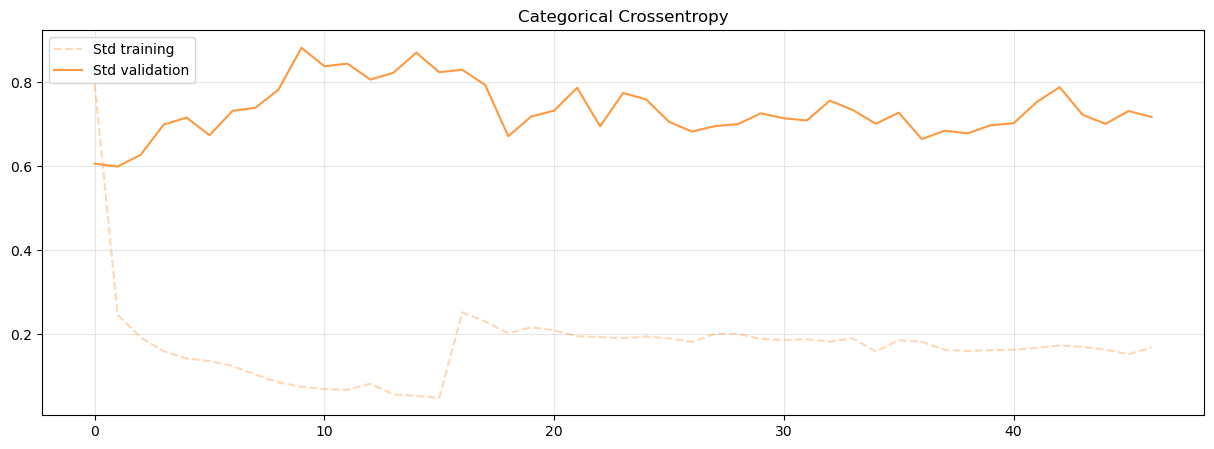

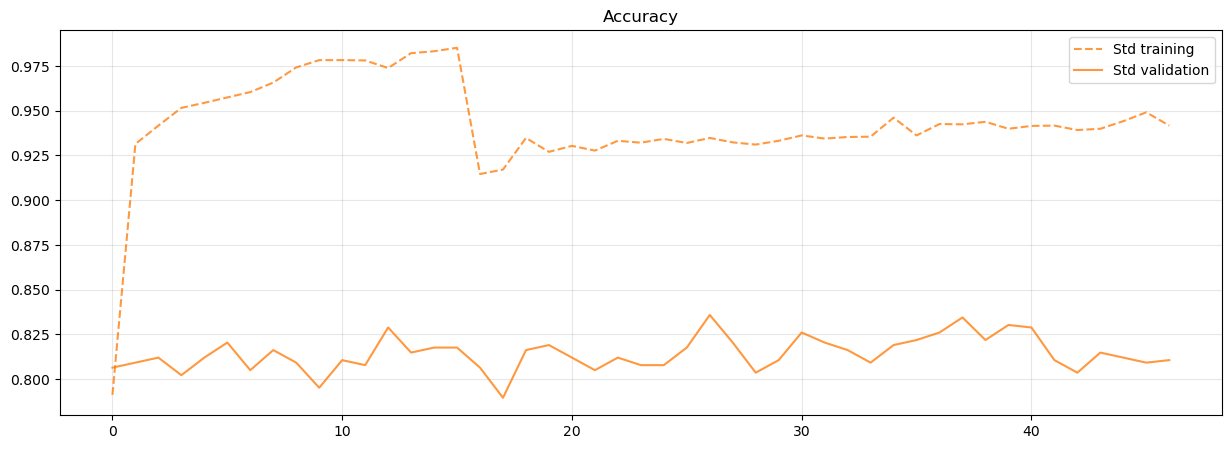

In [ ]:
history = classifier_history

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()